In [2]:
!pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.3 MB/s eta 0:00:00


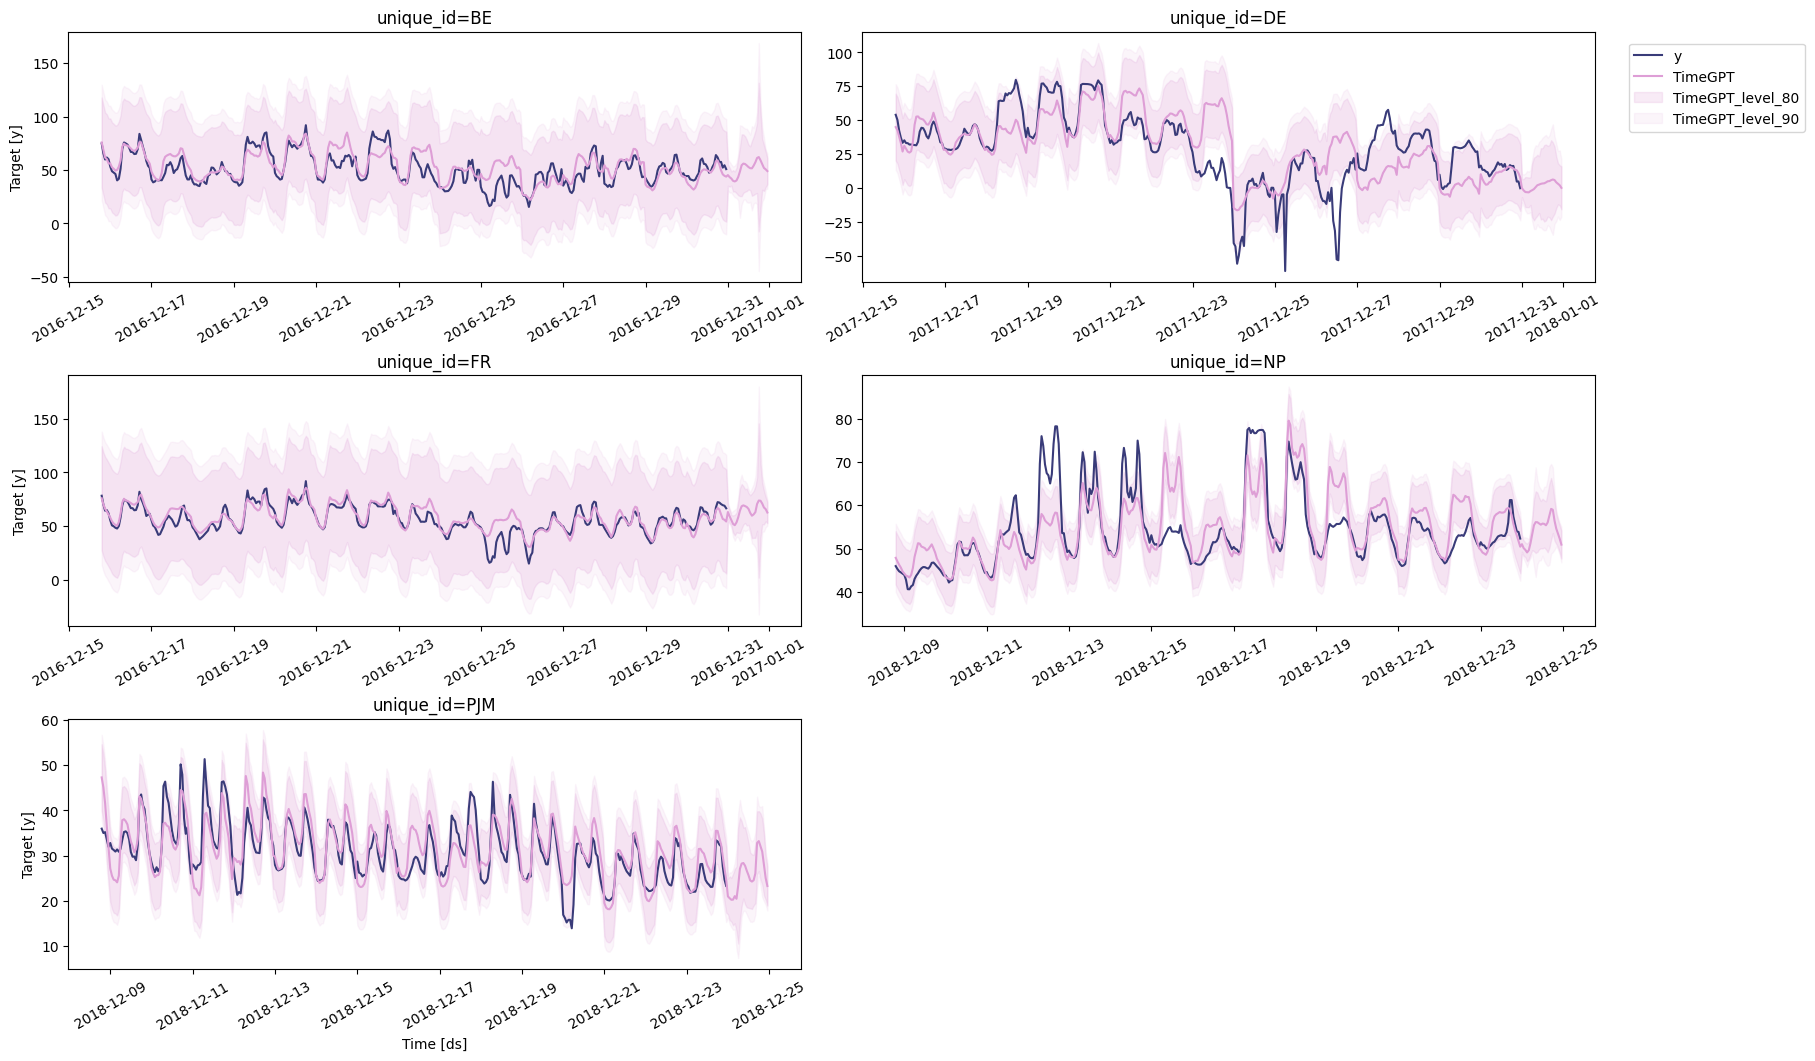

In [16]:
#part A
import pandas as pd
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-voYIZPGwIOiW00ryhABHwg850p8NvAr6f1rhTF8U7CLOTvRwD4FciQabkZENnLZpHHjambfC3FBelbEt'
)

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
df.head()
nixtla_client.plot(df)

timegpt_fcst_multiseries_df = nixtla_client.forecast(df=df, h=24, level=[80, 90])
timegpt_fcst_multiseries_df.head()

nixtla_client.plot(df, timegpt_fcst_multiseries_df, max_insample_length=365, level=[80, 90])

timegpt_fcst_multiseries_with_history_df = nixtla_client.forecast(df=df, h=24, level=[80, 90], add_history=True)
timegpt_fcst_multiseries_with_history_df.head()

nixtla_client.plot(
    df,
    timegpt_fcst_multiseries_with_history_df.groupby('unique_id').tail(365 + 24),
    max_insample_length=365,
    level=[80, 90],
)

In [17]:
#part B

import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-voYIZPGwIOiW00ryhABHwg850p8NvAr6f1rhTF8U7CLOTvRwD4FciQabkZENnLZpHHjambfC3FBelbEt'
)

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df, h=12, finetune_steps=10,
    time_col='timestamp', target_col='value',
)

nixtla_client.plot(
    df, timegpt_fcst_finetune_df,
    time_col='timestamp', target_col='value',
)

train = df[:-24]
test = df[-24:]

depths = [1, 2, 3, 4, 5]

test = test.copy()

for depth in depths:
    preds_df = nixtla_client.forecast(
    df=train,
    h=24,
    finetune_steps=5,
    finetune_depth=depth,
    time_col='timestamp',
    target_col='value')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_depth{depth}'] = preds

test['unique_id'] = 0

evaluation = evaluate(test, metrics=[mae, mse], time_col="timestamp", target_col="value")
evaluation

,unique_id,metric,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5
0,0,mae,22.675540,17.908963,21.243560,24.745096,29.183245
1,0,mse,677.254283,461.320852,671.131971,991.835359,1147.905234


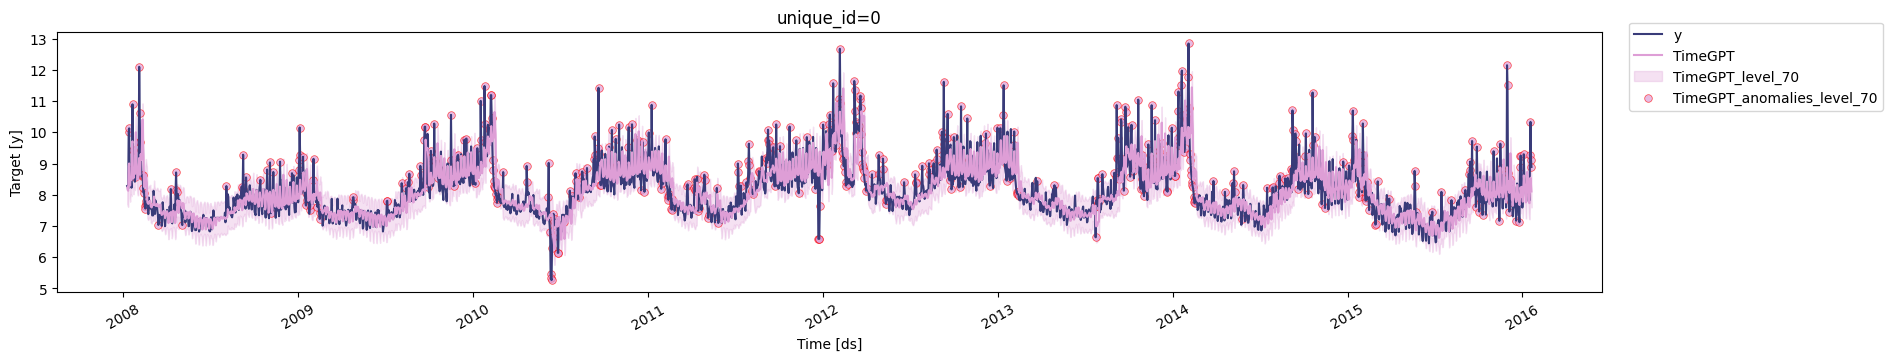

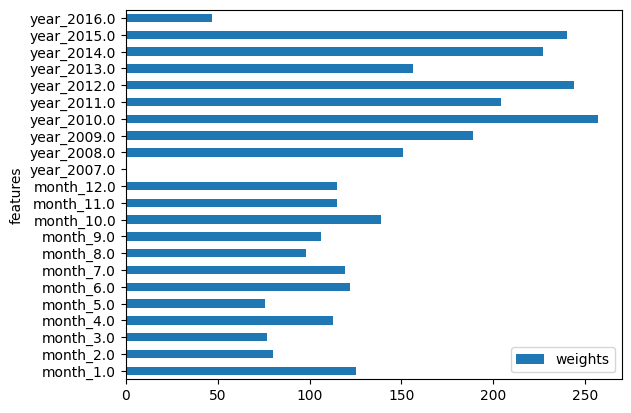

In [18]:
#part C

import pandas as pd
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-voYIZPGwIOiW00ryhABHwg850p8NvAr6f1rhTF8U7CLOTvRwD4FciQabkZENnLZpHHjambfC3FBelbEt'
)

df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/peyton-manning.csv')
df.head()

nixtla_client.plot(df, max_insample_length=365)

anomalies_df = nixtla_client.detect_anomalies(df, freq='D')
anomalies_df.head()

nixtla_client.plot(df, anomalies_df)

anomalies_df_x = nixtla_client.detect_anomalies(
    df,
    freq='D',
    date_features=['month', 'year'],
    date_features_to_one_hot=True,
)

nixtla_client.weights_x.plot.barh(x='features', y='weights')

anomalies_df = nixtla_client.detect_anomalies(
    df,
    freq='D',
    level=70
)

nixtla_client.plot(df, anomalies_df)

In [20]:
#part d

import time
import requests
import pandas as pd

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-voYIZPGwIOiW00ryhABHwg850p8NvAr6f1rhTF8U7CLOTvRwD4FciQabkZENnLZpHHjambfC3FBelbEt'
)

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/refs/heads/main/datasets/pjm_in_zone.csv')
df['ds'] = pd.to_datetime(df['ds'])

df.groupby('unique_id').head(2)

nixtla_client.plot(
    df,
    max_insample_length=365,
)

test_df = df.groupby('unique_id').tail(96)                                                             # 96 = 4 days (96 *  1 day/24h )

input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)

start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])

evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

!pip install neuralforecast

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

train_df = df.groupby('unique_id').apply(lambda group: group.iloc[:-96]).reset_index(drop=True)

horizon = 96

models = [NHITS(h=horizon, input_size = 5*horizon, scaler_type='robust', batch_size=16, valid_batch_size=8)]

nf = NeuralForecast(models=models, freq='H')

start = time.time()

nf.fit(df=train_df)
nhits_preds = nf.predict()

end = time.time()

nhits_duration = end - start

print(f"Time (N-HiTS): {nhits_duration}")

preds_df = pd.merge(test_df, nhits_preds, 'left', ['unique_id', 'ds'])

evaluation = evaluate(
    preds_df,
    metrics=[mae, smape],
    models=["NHITS"],
    target_col="y",
    id_col='unique_id'
)


average_metrics = evaluation.groupby('metric')['NHITS'].mean()
print(average_metrics)

<ipython-input-20-67f7cb566fcd>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)


Time (TimeGPT): 3.9330265522003174
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00


<ipython-input-20-67f7cb566fcd>:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby('unique_id').apply(lambda group: group.iloc[:-96]).reset_index(drop=True)
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
/usr/local/lib/python3.10/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.10/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Time (N-HiTS): 1027.195656299591
metric
mae      961.645964
smape      0.028194
Name: NHITS, dtype: float64


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


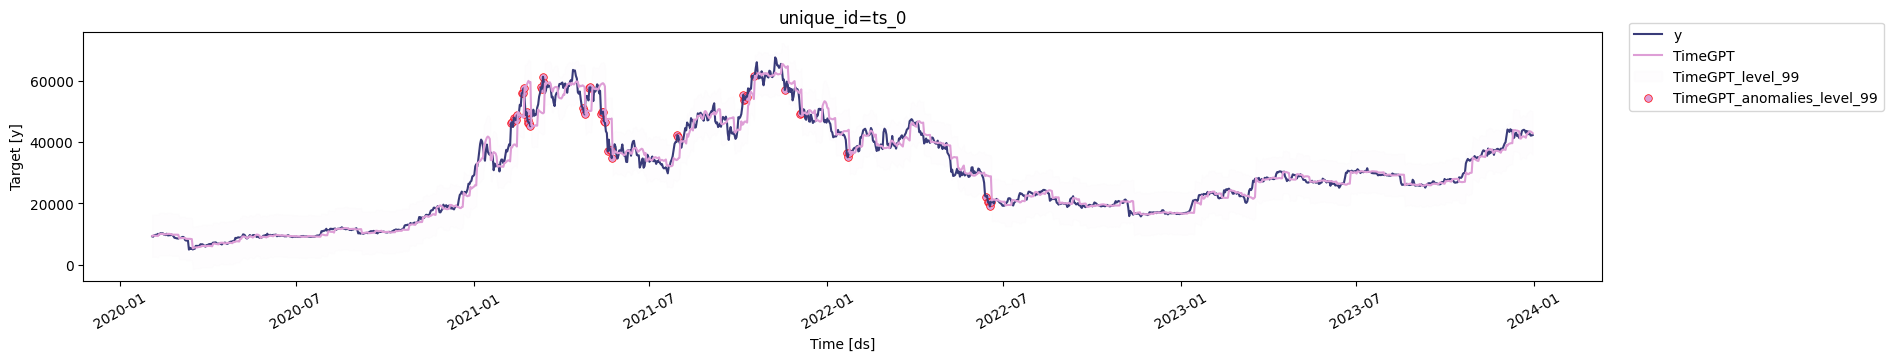

In [27]:
#part E

import pandas as pd
from nixtla import NixtlaClient

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/bitcoin_price_usd.csv', sep=',')
df.head()

df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-voYIZPGwIOiW00ryhABHwg850p8NvAr6f1rhTF8U7CLOTvRwD4FciQabkZENnLZpHHjambfC3FBelbEt'
)

nixtla_client.plot(df)
nixtla_client.plot(df, time_col='ds', target_col='y')
level = [50,80,90] # confidence levels

fcst = nixtla_client.forecast(df, h=7, level=level)
fcst.head()

nixtla_client.plot(df, fcst, level=level)
nixtla_client.plot(df, fcst, level=level, max_insample_length=60)

forecast = nixtla_client.forecast(df, h=7, level=level, add_history=True)
forecast.head()

nixtla_client.plot(df, forecast, level=level)
anomalies_df = nixtla_client.detect_anomalies(df)
nixtla_client.plot(df, anomalies_df, plot_anomalies=True)